In [1]:
import pandas as pd
import json

In [2]:
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [3]:
RESULT_PATH = '../logs/l3_NOmultiprocess_threshold.txt'

In [4]:
general_agg_functions = {
    'total_equations': 'mean',
    'duration': 'mean',
    'equations_used': 'mean',
    'faulted_coeffs': 'mean',
    'filtered_equations': 'mean',
    'false_positive_rate': 'mean',
    'equations_used': 'mean',
    'num_signatures': 'mean'
}

In [5]:
def load_results(path: str) -> pd.DataFrame:
    LEVEL_TO_NL = {2: 1024, 3: 1280, 5: 1792}
    LEVEL_TO_BETA = {2: 78, 3: 196, 5: 120}
    
    results = []
    with open(path, 'r') as file:
        for line in file.readlines():
            try:
                results.append(json.loads(line))
            except json.JSONDecodeError:
                    pass
    results = [result | {'attack_no': i} for i, result in enumerate(results)]
    
    df = pd.json_normalize(data=results, record_path='entry_results', meta=[key for key in results[0].keys() if key != 'entry_results'])
    first_columns = ['attack_no', 'm', 'threshold', 'failure']
    df = df.reindex(columns=first_columns + list(set(df.columns) - set(first_columns)))
    df = df[df['threshold'] > 0]
    df['false_positive_rate'] = (df['filtered_equations'] - df['faulted_coeffs']) / df['filtered_equations']
    df['f'] = LEVEL_TO_NL[df['nist_param_level'].max()] - df['m']
    df['percent'] = df['m'] / LEVEL_TO_NL[df['nist_param_level'].max()]
    df['beta'] = LEVEL_TO_BETA[df['nist_param_level'].max()]
    return df

In [6]:
def load_results_per_attack(path: str) -> pd.DataFrame:
    df = load_results(path)
    df = df.drop('failure_reason', axis=1)
    
    agg_functions = general_agg_functions | {'failure': 'any'}
    no_agg = list(set(df.columns) - set(agg_functions.keys()))
    
    df_per_attack = df.groupby(no_agg).agg(agg_functions).reset_index().set_index('attack_no')
        
    return df_per_attack


In [7]:
def load_results_per_attack_run(df_per_attack: pd.DataFrame) -> pd.DataFrame:
    if type(df_per_attack) is str:
        df_per_attack = load_results_per_attack(df_per_attack)
    df_per_attack = df_per_attack.reset_index().drop('attack_no', axis=1)
    
    agg_functions = general_agg_functions | {'failure': 'sum'}
    no_agg = list(set(df_per_attack.columns) - set(agg_functions.keys()))
    df_per_attack_run = df_per_attack.groupby(no_agg).agg(agg_functions).reset_index().set_index(['m', 'threshold'])
    df_per_attack_run['failure'] = df_per_attack_run['failure'] >= 2
    df_per_attack_run = df_per_attack_run.sort_index(ascending=[True, False])
    return df_per_attack_run
    

In [8]:
def load_results_per_attack_run_successful(df_per_attack_run: pd.DataFrame) -> pd.DataFrame:
    if type(df_per_attack_run) is str:
        df_per_attack_run = load_results_per_attack_run(df_per_attack_run)
    df_per_attack_run = df_per_attack_run.reset_index()
        
    df_per_attack_run = df_per_attack_run[df_per_attack_run['failure'] == False]
    # df_per_attack_run = df_per_attack_run[df_per_attack_run['threshold'] < df_per_attack_run['beta']]
    df_per_attack_run = df_per_attack_run[df_per_attack_run['f'] <= 4]
    
    df_per_attack_run['threshold_percent'] = df_per_attack_run['threshold'] / df_per_attack_run['beta']
    df_per_attack_run['actual_surplus_of_equations'] = df_per_attack_run['faulted_coeffs'] - 256
        
    return df_per_attack_run.set_index(['m', 'threshold'])

In [9]:
df = load_results(RESULT_PATH)
df

,attack_no,m,threshold,failure,failure_reason,faulted_coeffs,filtered_equations,notion_of_success,total_equations,num_signatures,equations_used,timeout_limit,duration,nist_param_level,false_positive_rate,f,percent,beta
0,0,1265,196,False,NaN,269,280,256,23296,91,269.0,300,0.511964,3,0.039286,15,0.988281,196
1,0,1265,196,False,NaN,283,286,256,23296,91,283.0,300,0.546724,3,0.010490,15,0.988281,196
2,0,1265,196,False,NaN,261,265,256,23296,91,261.0,300,0.342683,3,0.015094,15,0.988281,196
3,0,1265,196,False,NaN,258,267,256,23296,91,258.0,300,0.469741,3,0.033708,15,0.988281,196
4,0,1265,196,False,NaN,294,303,256,23296,91,294.0,300,0.462233,3,0.029703,15,0.988281,196
5,1,1265,196,False,NaN,263,274,256,22528,88,263.0,300,2.136192,3,0.040146,15,0.988281,196
6,1,1265,196,False,NaN,278,286,256,22528,88,278.0,300,0.453357,3,0.027972,15,0.988281,196
7,1,1265,196,False,NaN,258,267,256,22528,88,258.0,300,0.531526,3,0.033708,15,0.988281,196
8,1,1265,196,False,NaN,265,273,256,22528,88,265.0,300,0.403163,3,0.029304,15,0.988281,196
9,1,1265,196,False,NaN,256,265,256,22528,88,256.0,300,0.463275,3,0.033962,15,0.988281,196


In [10]:
df_per_attack = load_results_per_attack(RESULT_PATH)
df_per_attack

,percent,beta,threshold,notion_of_success,f,timeout_limit,m,nist_param_level,total_equations,duration,equations_used,faulted_coeffs,filtered_equations,false_positive_rate,num_signatures,failure
attack_no,,,,,,,,,,,,,,,,
0,0.988281,196,196,256,15,300,1265,3,23296.0,0.466669,273.000000,273.0,280.2,0.025656,91.0,False
1,0.988281,196,196,256,15,300,1265,3,22528.0,0.797503,264.000000,264.0,273.0,0.033018,88.0,False
2,0.989062,196,196,256,14,300,1266,3,24576.0,0.493188,268.800000,268.8,277.6,0.031608,96.0,False
3,0.989062,196,196,256,14,300,1266,3,24576.0,0.500938,268.800000,268.8,279.6,0.037957,96.0,False
4,0.989844,196,196,256,13,300,1267,3,27136.0,0.544569,275.800000,275.8,288.6,0.044234,106.0,False
5,0.989844,196,196,256,13,300,1267,3,28672.0,1.059804,291.200000,291.2,301.0,0.032753,112.0,False
6,0.990625,196,196,256,12,300,1268,3,28672.0,0.716258,268.800000,268.8,281.0,0.043271,112.0,False
7,0.990625,196,196,256,12,300,1268,3,28672.0,0.534477,268.800000,268.8,280.0,0.039597,112.0,False
8,0.991406,196,196,256,11,300,1269,3,32000.0,0.477083,275.000000,275.0,284.8,0.034427,125.0,False


In [11]:
df_per_attack_run = load_results_per_attack_run(RESULT_PATH)
df_per_attack_run

,,percent,beta,notion_of_success,f,timeout_limit,nist_param_level,total_equations,duration,equations_used,faulted_coeffs,filtered_equations,false_positive_rate,num_signatures,failure
m,threshold,,,,,,,,,,,,,,
1265,196,0.988281,196,256,15,300,3,2.291200e+04,0.632086,268.500000,268.500000,276.600000,0.029337,89.500000,False
1266,196,0.989062,196,256,14,300,3,2.457600e+04,0.497063,268.800000,268.800000,278.600000,0.034782,96.000000,False
1267,196,0.989844,196,256,13,300,3,2.790400e+04,0.802187,283.500000,283.500000,294.800000,0.038493,109.000000,False
1268,196,0.990625,196,256,12,300,3,2.867200e+04,0.625367,268.800000,268.800000,280.500000,0.041434,112.000000,False
1269,196,0.991406,196,256,11,300,3,3.225600e+04,0.507470,277.200000,277.200000,287.400000,0.035579,126.000000,False
1270,196,0.992188,196,256,10,300,3,3.392000e+04,1.236260,259.500000,265.000000,279.800000,0.052723,132.500000,False
1271,196,0.992969,196,256,9,300,3,3.980800e+04,2.887125,280.000000,280.000000,294.000000,0.047401,155.500000,False
1272,196,0.993750,196,256,8,300,3,4.416000e+04,3.569296,276.100000,276.100000,291.000000,0.051546,172.500000,False
1273,196,0.994531,196,256,7,300,3,5.260800e+04,2.320116,287.700000,287.700000,306.400000,0.061128,205.500000,False


In [12]:
df_per_attack_run_successful = load_results_per_attack_run_successful(RESULT_PATH)
df_per_attack_run_successful

,,percent,beta,notion_of_success,f,timeout_limit,nist_param_level,total_equations,duration,equations_used,faulted_coeffs,filtered_equations,false_positive_rate,num_signatures,failure,threshold_percent,actual_surplus_of_equations
m,threshold,,,,,,,,,,,,,,,,
1276,194,0.996875,196,256,4,300,3,87168.000000,34.742812,272.400000,272.400000,301.900000,0.097292,340.500000,False,0.989796,16.400000
1277,178,0.997656,196,256,3,300,3,119552.000000,40.994396,280.200000,280.200000,319.600000,0.123886,467.000000,False,0.908163,24.200000
1278,45,0.998437,196,256,2,300,3,179882.666667,37.565083,287.066667,278.666667,294.266667,0.052907,702.666667,False,0.229592,22.666667


In [13]:
l2 = load_results_per_attack_run_successful('../logs/l2_threshold_only.txt').reset_index().set_index('f').add_prefix('l2_')
l3 = load_results_per_attack_run_successful('../logs/l3_NOmultiprocess_threshold.txt').reset_index().set_index('f').add_prefix('l3_')
l5 = load_results_per_attack_run_successful('../logs/l5_threshold_only.txt').reset_index().set_index('f').add_prefix('l5_')
all_lvls = l2.join([l3, l5], how='outer').sort_index()
all_lvls

,l2_m,l2_threshold,l2_percent,l2_beta,l2_notion_of_success,l2_timeout_limit,l2_nist_param_level,l2_total_equations,l2_duration,l2_equations_used,l2_faulted_coeffs,l2_filtered_equations,l2_false_positive_rate,l2_num_signatures,l2_failure,l2_threshold_percent,l2_actual_surplus_of_equations,l3_m,l3_threshold,l3_percent,l3_beta,l3_notion_of_success,l3_timeout_limit,l3_nist_param_level,l3_total_equations,l3_duration,l3_equations_used,l3_faulted_coeffs,l3_filtered_equations,l3_false_positive_rate,l3_num_signatures,l3_failure,l3_threshold_percent,l3_actual_surplus_of_equations,l5_m,l5_threshold,l5_percent,l5_beta,l5_notion_of_success,l5_timeout_limit,l5_nist_param_level,l5_total_equations,l5_duration,l5_equations_used,l5_faulted_coeffs,l5_filtered_equations,l5_false_positive_rate,l5_num_signatures,l5_failure,l5_threshold_percent,l5_actual_surplus_of_equations
f,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1791,13,0.999442,120,256,300,5,618240.0,2.438463,274.000000,274.000000,287.428571,0.046629,2415.0,False,0.108333,18.000000
2,1022.0,35.0,0.998047,78.0,256.0,300.0,2.0,139520.0,31.936740,277.50,272.833333,308.166667,0.115042,545.0,False,0.448718,16.833333,1278.0,45.0,0.998437,196.0,256.0,300.0,3.0,179882.666667,37.565083,287.066667,278.666667,294.266667,0.052907,702.666667,False,0.229592,22.666667,1790,103,0.998884,120,256,300,5,242432.0,23.560695,271.142857,271.142857,318.714286,0.149238,947.0,False,0.858333,15.142857
3,1021.0,73.0,0.997070,78.0,256.0,300.0,2.0,93184.0,1.954949,273.25,273.250000,322.750000,0.153060,364.0,False,0.935897,17.250000,1277.0,178.0,0.997656,196.0,256.0,300.0,3.0,119552.000000,40.994396,280.200000,280.200000,319.600000,0.123886,467.000000,False,0.908163,24.200000,1789,120,0.998326,120,256,300,5,164736.0,0.607434,275.857143,275.857143,311.857143,0.115068,643.5,False,1.000000,19.857143
4,1020.0,78.0,0.996094,78.0,256.0,300.0,2.0,70656.0,1.242657,276.00,276.000000,318.250000,0.132355,276.0,False,1.000000,20.000000,1276.0,194.0,0.996875,196.0,256.0,300.0,3.0,87168.000000,34.742812,272.400000,272.400000,301.900000,0.097292,340.500000,False,0.989796,16.400000,1788,120,0.997768,120,256,300,5,124160.0,16.866873,277.357143,277.357143,306.785714,0.095991,485.0,False,1.000000,21.357143


In [14]:
all_lvls[['l2_threshold', 'l3_threshold', 'l5_threshold']]

,l2_threshold,l3_threshold,l5_threshold
f,,,
1,NaN,NaN,13
2,35.0,45.0,103
3,73.0,178.0,120
4,78.0,194.0,120


<AxesSubplot:xlabel='number of zero-coefficients (f)', ylabel='threshold (%)'>

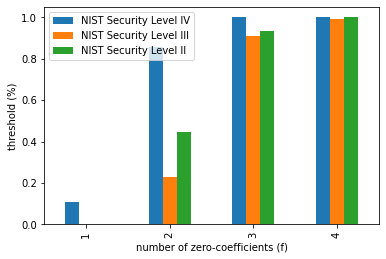

In [15]:
ax = all_lvls[['l5_threshold_percent', 'l3_threshold_percent', 'l2_threshold_percent']].rename(columns={
        'l5_threshold_percent': 'NIST Security Level IV',
        'l3_threshold_percent': 'NIST Security Level III',
        'l2_threshold_percent': 'NIST Security Level II',
        }
                                                         ).plot(kind='bar')
ax.set_xlabel('number of zero-coefficients (f)')
ax.set_ylabel('threshold (%)')
fig = ax.get_figure()
fig.savefig(f'dilithium_threshold_percent.pdf', format="pdf", bbox_inches='tight')
ax

<AxesSubplot:xlabel='number of zero-coefficients (f)', ylabel='threshold'>

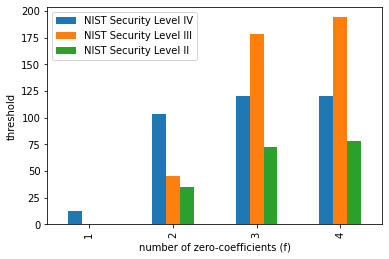

In [16]:
ax = all_lvls[['l5_threshold', 'l3_threshold', 'l2_threshold']].rename(columns={
        'l5_threshold': 'NIST Security Level IV',
        'l3_threshold': 'NIST Security Level III',
        'l2_threshold': 'NIST Security Level II',
        }
                                                         ).plot(kind='bar')
ax.set_xlabel('number of zero-coefficients (f)')
ax.set_ylabel('threshold')
fig = ax.get_figure()
fig.savefig(f'dilithium_threshold.pdf', format="pdf", bbox_inches='tight')
ax

<AxesSubplot:xlabel='number of zero-coefficients (f)', ylabel='average false-positive rate'>

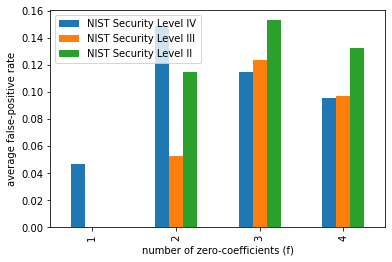

In [17]:
ax = all_lvls[['l5_false_positive_rate', 'l3_false_positive_rate', 'l2_false_positive_rate']].rename(columns={
        'l5_false_positive_rate': 'NIST Security Level IV',
        'l3_false_positive_rate': 'NIST Security Level III',
        'l2_false_positive_rate': 'NIST Security Level II',
        }
                                                         ).plot(kind='bar')
ax.set_xlabel('number of zero-coefficients (f)')
ax.set_ylabel('average false-positive rate')
fig = ax.get_figure()
fig.savefig(f'dilithium_threshold_fpr.pdf', format="pdf", bbox_inches='tight')
ax

<AxesSubplot:xlabel='number of zero-coefficients (f)', ylabel='average false-positive rate (simulated)'>

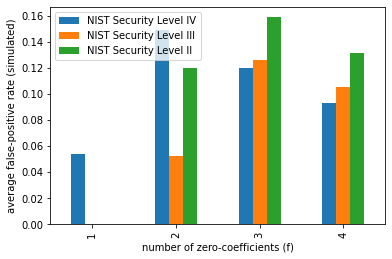

In [18]:
all_lvls_simed = pd.read_json('simulated_false_positive_rates.json')
# avg of 20 attackes per security level, per f
ax = all_lvls_simed[['l5_false_positive_rate', 'l3_false_positive_rate', 'l2_false_positive_rate']].rename(columns={
        'l5_false_positive_rate': 'NIST Security Level IV',
        'l3_false_positive_rate': 'NIST Security Level III',
        'l2_false_positive_rate': 'NIST Security Level II',
        }
                                                         ).plot(kind='bar')
ax.set_xlabel('number of zero-coefficients (f)')
ax.set_ylabel('average false-positive rate (simulated)')
fig = ax.get_figure()
fig.savefig(f'dilithium_threshold_fpr_simed.pdf', format="pdf", bbox_inches='tight')
ax

<AxesSubplot:xlabel='number of zero-coefficients (f)', ylabel='average signature count'>

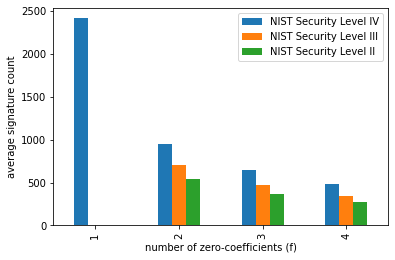

In [19]:
ax = all_lvls[['l5_num_signatures', 'l3_num_signatures', 'l2_num_signatures']].rename(columns={
        'l5_num_signatures': 'NIST Security Level IV',
        'l3_num_signatures': 'NIST Security Level III',
        'l2_num_signatures': 'NIST Security Level II',
        }
                                                         ).plot(kind='bar')
ax.set_xlabel('number of zero-coefficients (f)')
ax.set_ylabel('average signature count')
fig = ax.get_figure()
fig.savefig(f'dilithium_threshold_sigcount.pdf', format="pdf", bbox_inches='tight')
ax

<AxesSubplot:xlabel='number of zero-coefficients (f)', ylabel='average actual surplus of equations'>

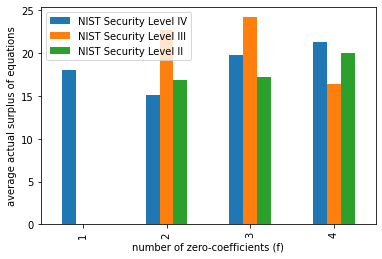

In [20]:
ax = all_lvls[['l5_actual_surplus_of_equations', 'l3_actual_surplus_of_equations', 'l2_actual_surplus_of_equations']].rename(columns={
        'l5_actual_surplus_of_equations': 'NIST Security Level IV',
        'l3_actual_surplus_of_equations': 'NIST Security Level III',
        'l2_actual_surplus_of_equations': 'NIST Security Level II',
        }
                                                         ).plot(kind='bar')
ax.set_xlabel('number of zero-coefficients (f)')
ax.set_ylabel('average actual surplus of equations')
fig = ax.get_figure()
fig.savefig(f'dilithium_threshold_actual_surplus.pdf', format="pdf", bbox_inches='tight')
ax